
# **QAI Portfolio Optimization PoC**



Classical (Greedy) selected indices: [ 3 35 51 53 23 40 45  8 32 30]
Classical metrics: {'return': 0.45421943478625704, 'variance': 0.008187968972862645, 'std': 0.09048739676254725, 'sharpe': 5.019698334102795, 'tx_cost': 0.002}
Classical sector penalty: 0.0
Classical total objective (lower is better): -0.44403146581339437

Simulated annealing finished in 50.4 sec
SA best energy: -0.6199060961115858
SA best metrics: {'return': 0.6559563816711736, 'variance': 0.03405028555958787, 'std': 0.18452719463425402, 'sharpe': 3.5547951778670113, 'tx_cost': 0.002}
SA best sector penalty: 0.0
SA best tx cost: 0.002
SA selection indices: [ 3 13 14 21 31 32 35 49 53 56]

--- Summary Comparison ---
Classical (Greedy) objective (lower is better): -0.44403146581339437
SA (QAI) best energy (lower is better): -0.6199060961115858

Classical metrics: {'return': 0.45421943478625704, 'variance': 0.008187968972862645, 'std': 0.09048739676254725, 'sharpe': 5.019698334102795, 'tx_cost': 0.002}
SA best metrics: 

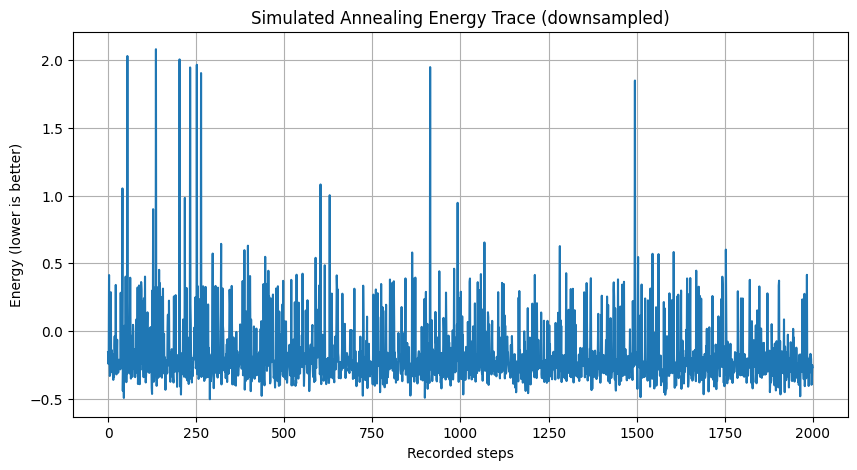

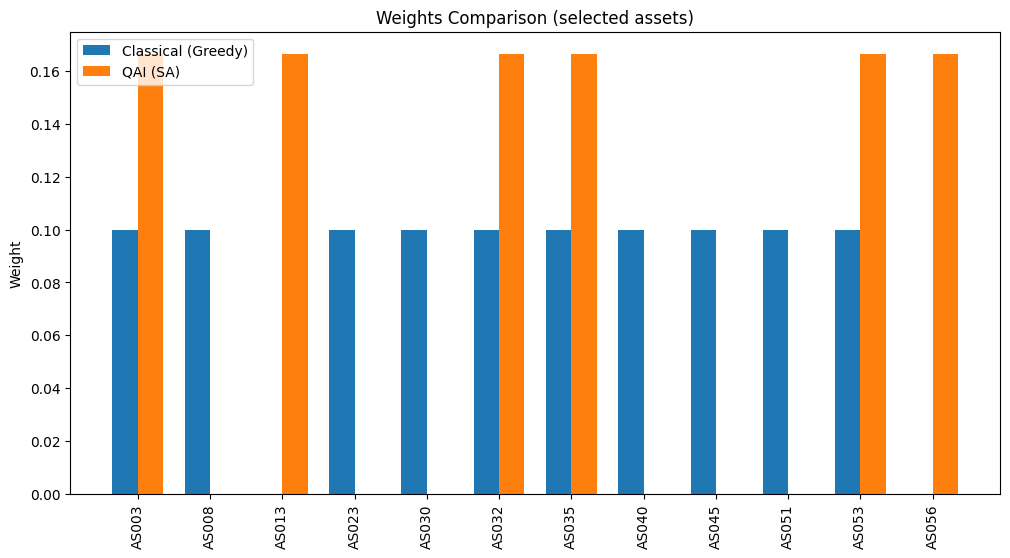


Artifacts saved to /mnt/data/portfolio_poc_combinatorial

Notes:
 - SA runtime depends on SA_STEPS_PER_TEMP and N_ASSETS. Reduce SA_STEPS_PER_TEMP for faster runs.
 - Increase N_ASSETS and SA_STEPS_PER_TEMP to stress-test bigger combinatorial spaces.
 - For production-level QAOA replace SA loop with QAOA or D-Wave sampler calls (requires QP library or cloud).


In [2]:
# QAI Portfolio PoC — COMBINATORIAL VERSION (Colab-ready)
# Paste into Google Colab. Optional installs:
# !pip install yfinance scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, random, time
from datetime import datetime
from pathlib import Path

# ---------------------
# PARAMETERS (edit in Colab)
# ---------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

N_ASSETS = 60            # number of assets (increase to show scale effects)
K_SELECT = 10            # cardinality: number of assets to pick
MAX_WEIGHT = 0.2         # max weight per asset (after normalization)
RISK_AVERSION = 1.0      # lambda (higher -> more risk averse)
TRANSACTION_COST_RATE = 0.002   # proportional transaction cost per unit weight change (example)
SECTORS = 6              # number of sectors
SECTOR_CAP = 0.35        # max fraction of portfolio per sector (e.g., 35%)
NUM_DAYS = 252           # synth history days
SA_INIT_TEMP = 1.0
SA_FINAL_TEMP = 1e-3
SA_ALPHA = 0.995
SA_STEPS_PER_TEMP = 800   # tune for runtime; lower for faster runs
MAX_SA_TEMPS = 1200       # safety cap
OUTPUT_DIR = "/mnt/data/portfolio_poc_combinatorial"

# ---------------------
# Synthetic data (works offline). Replace with yfinance fetch if you want real tickers.
# ---------------------
tickers = [f"AS{str(i).zfill(3)}" for i in range(N_ASSETS)]
dates = pd.bdate_range(end=datetime.today(), periods=NUM_DAYS)
# Create per-asset daily returns with varying means & vol
mu_daily = np.random.uniform(0.00005, 0.0007, size=N_ASSETS)   # daily mean (≈ 1.3% - 18% annual)
sigma_daily = np.random.uniform(0.008, 0.035, size=N_ASSETS)   # daily vol
prices = pd.DataFrame(index=dates, columns=tickers, dtype=float)
for i,t in enumerate(tickers):
    r = np.random.normal(loc=mu_daily[i], scale=sigma_daily[i], size=NUM_DAYS)
    prices[t] = 100 * np.cumprod(1 + r)
returns = prices.pct_change().dropna()
mu = returns.mean().values * NUM_DAYS      # annualized expected returns (vector)
cov = returns.cov().values * NUM_DAYS       # annualized covariance matrix (NxN)

# Assign each asset to a random sector
sector_ids = np.random.randint(0, SECTORS, size=N_ASSETS)
sector_map = {tickers[i]: int(sector_ids[i]) for i in range(N_ASSETS)}

# Initial/current portfolio (for transaction cost calculation) — assume uniform small holding
initial_weights = np.zeros(N_ASSETS)  # start with zero holdings to highlight transaction cost effect

# ---------------------
# Helper functions
# ---------------------
def compute_markowitz_weights_for_subset(selected_idx, mu_vec, cov_mat, max_weight=MAX_WEIGHT, risk_aversion=RISK_AVERSION):
    """
    Given a subset of asset indices (selected_idx), compute optimal continuous weights (sum to 1),
    solving: max w^T mu - risk_aversion * w^T Sigma w subject to w >=0 and w <= max_weight.
    This is a small convex QP; we use closed-form unconstrained then project (fast heuristic).
    For a small subset, one could call scipy.optimize SLSQP; to keep simple & fast we use a projected step.
    """
    if len(selected_idx) == 0:
        return np.array([])
    mu_s = mu_vec[selected_idx]
    cov_s = cov_mat[np.ix_(selected_idx, selected_idx)]
    # naive closed-form for unconstrained mean-variance: w ~ inv(2*lambda*Sigma) * mu
    try:
        inv_term = np.linalg.inv(2 * risk_aversion * cov_s + 1e-8*np.eye(len(selected_idx)))
        w_raw = inv_term.dot(mu_s)
    except np.linalg.LinAlgError:
        # fallback to pseudo-inverse
        inv_term = np.linalg.pinv(2 * risk_aversion * cov_s + 1e-8*np.eye(len(selected_idx)))
        w_raw = inv_term.dot(mu_s)
    # Remove negatives, clip to max_weight, normalize
    w_pos = np.maximum(w_raw, 0.0)
    if w_pos.sum() == 0:
        w = np.repeat(1.0/len(selected_idx), len(selected_idx))
    else:
        # clip iteratively to enforce max_weight feasibly
        w = w_pos.copy()
        # iterative clipping: if any weight > max_weight, clip and renorm remaining
        for _ in range(10):
            over = w > max_weight
            if not over.any():
                break
            w[over] = max_weight
            rem = (~over)
            if rem.sum() == 0:
                # all clipped -> distribute equally
                w = np.clip(w, 0, max_weight)
                break
            # rescale remaining to sum to 1 - sum(clipped)
            remaining_sum = w[rem].sum()
            if remaining_sum == 0:
                w[rem] = (1.0 - w[over].sum()) / rem.sum()
            else:
                w[rem] = w[rem] / remaining_sum * (1.0 - w[over].sum())
        # final normalize (safety)
        w = np.clip(w, 0, max_weight)
        if w.sum() == 0:
            w = np.repeat(1.0/len(selected_idx), len(selected_idx))
        else:
            w = w / w.sum()
    return w

def portfolio_metrics_from_weights(full_w, mu_vec, cov_mat, initial_w=None, tx_cost_rate=TRANSACTION_COST_RATE):
    """
    Given full weight vector of length N, compute expected return, variance, std, sharpe,
    and transaction cost penalty (based on moving from initial_w).
    """
    exp_return = float(full_w.dot(mu_vec))
    variance = float(full_w.dot(cov_mat.dot(full_w)))
    std = math.sqrt(variance)
    sharpe = exp_return / std if std > 0 else float("nan")
    tx_cost = 0.0
    if initial_w is not None:
        tx_cost = float(tx_cost_rate * np.abs(full_w - initial_w).sum())   # simplistic L1 proportional cost
    return {"return": exp_return, "variance": variance, "std": std, "sharpe": sharpe, "tx_cost": tx_cost}

def sector_cap_penalty(full_w, sector_ids_array, cap=SECTOR_CAP):
    # compute sum weight per sector, add penalty if exceeds cap
    penalty = 0.0
    for s in np.unique(sector_ids_array):
        sec_sum = full_w[sector_ids_array==s].sum()
        if sec_sum > cap:
            penalty += (sec_sum - cap)**2 * 100.0   # squared penalty scaled
    return penalty

# ---------------------
# Classical baseline (Greedy + local reweighting)
# Greedy: rank assets by mu/sigma and pick top K, then compute continuous weights on subset.
# ---------------------
asset_scores = mu / (np.sqrt(np.diag(cov)) + 1e-12)
greedy_idx = np.argsort(-asset_scores)[:K_SELECT]  # top K by score
greedy_weights_subset = compute_markowitz_weights_for_subset(greedy_idx, mu, cov, MAX_WEIGHT, RISK_AVERSION)
# convert to full vector
classical_full_w = np.zeros(N_ASSETS)
classical_full_w[greedy_idx] = greedy_weights_subset
classical_metrics = portfolio_metrics_from_weights(classical_full_w, mu, cov, initial_weights)

# Apply sector penalty & tx cost for classical objective (for fair comparison)
classical_sector_pen = sector_cap_penalty(classical_full_w, sector_ids, SECTOR_CAP)
classical_total_obj = -(classical_metrics["return"] - RISK_AVERSION * classical_metrics["variance"]) + classical_sector_pen + classical_metrics["tx_cost"]

print("Classical (Greedy) selected indices:", greedy_idx)
print("Classical metrics:", classical_metrics)
print("Classical sector penalty:", classical_sector_pen)
print("Classical total objective (lower is better):", classical_total_obj)

# ---------------------
# QUBO / Simulated annealing over selection vectors (binary vector length N with exactly K ones)
# We enforce cardinality by proposing swaps (one in, one out) to keep exactly K selections.
# Energy = negative of (return - λ variance) + sector cap penalty + tx cost penalty
# ---------------------
def selection_to_full_weights(selection_vec):
    """Given binary selection vector (N,), compute optimal continuous weights on selected subset."""
    selected_idx = np.where(selection_vec==1)[0]
    if selected_idx.size == 0:
        return np.zeros(N_ASSETS)
    w_subset = compute_markowitz_weights_for_subset(selected_idx.tolist(), mu, cov, MAX_WEIGHT, RISK_AVERSION)
    full_w = np.zeros(N_ASSETS)
    full_w[selected_idx] = w_subset
    return full_w

def energy_of_selection(selection_vec):
    full_w = selection_to_full_weights(selection_vec)
    metrics = portfolio_metrics_from_weights(full_w, mu, cov, initial_weights)
    # negative objective (we minimize energy)
    neg_obj = - (metrics["return"] - RISK_AVERSION * metrics["variance"])
    # add penalty for sector cap violation
    sec_pen = sector_cap_penalty(full_w, sector_ids, SECTOR_CAP)
    # add transaction cost
    tx = metrics["tx_cost"]
    total_energy = neg_obj + sec_pen + tx
    return total_energy, metrics, sec_pen, tx, full_w

# Initialize selection: random K indices
def random_selection_k(n, k):
    v = np.zeros(n, dtype=int)
    chosen = np.random.choice(n, size=k, replace=False)
    v[chosen] = 1
    return v

# Simulated annealing with swap proposals (keep cardinality K)
def sa_selection(n, k, init_temp=SA_INIT_TEMP, final_temp=SA_FINAL_TEMP, alpha=SA_ALPHA, steps_per_temp=SA_STEPS_PER_TEMP, max_temps=MAX_SA_TEMPS):
    sel = random_selection_k(n, k)
    best_sel = sel.copy()
    best_energy, best_metrics, best_sec_pen, best_tx, best_w = energy_of_selection(best_sel)
    cur_sel = sel.copy()
    cur_energy = best_energy
    history = []
    T = init_temp
    temp_steps = 0
    while T > final_temp and temp_steps < max_temps:
        for _ in range(steps_per_temp):
            # propose swap: pick one selected index to drop, one unselected to add
            selected_indices = np.where(cur_sel==1)[0]
            unselected_indices = np.where(cur_sel==0)[0]
            if len(selected_indices)==0 or len(unselected_indices)==0:
                # nothing to swap (edge)
                continue
            out_idx = np.random.choice(selected_indices)
            in_idx = np.random.choice(unselected_indices)
            new_sel = cur_sel.copy()
            new_sel[out_idx] = 0
            new_sel[in_idx] = 1
            new_energy, _, _, _, _ = energy_of_selection(new_sel)
            delta = new_energy - cur_energy
            if delta < 0 or np.random.rand() < np.exp(-delta / (T + 1e-12)):
                cur_sel = new_sel
                cur_energy = new_energy
                # evaluate best
                if new_energy < best_energy:
                    best_energy = new_energy
                    best_sel = new_sel.copy()
                    best_energy = new_energy
                    # optionally store best_w/metrics
            # optionally record current energy occasionally
            history.append(cur_energy)
        T = T * alpha
        temp_steps += 1
    # final evaluation of best
    best_energy, best_metrics, best_sec_pen, best_tx, best_w = energy_of_selection(best_sel)
    return {
        "best_selection": best_sel,
        "best_energy": best_energy,
        "best_metrics": best_metrics,
        "best_sector_penalty": best_sec_pen,
        "best_tx_cost": best_tx,
        "best_weights": best_w,
        "history": history
    }

# Run SA (this is the QAI/hybrid combinatorial search)
start_time = time.time()
sa_result = sa_selection(N_ASSETS, K_SELECT, init_temp=SA_INIT_TEMP, final_temp=SA_FINAL_TEMP,
                         alpha=SA_ALPHA, steps_per_temp=SA_STEPS_PER_TEMP, max_temps=200)
elapsed = time.time() - start_time
print(f"\nSimulated annealing finished in {elapsed:.1f} sec")
print("SA best energy:", sa_result["best_energy"])
print("SA best metrics:", sa_result["best_metrics"])
print("SA best sector penalty:", sa_result["best_sector_penalty"])
print("SA best tx cost:", sa_result["best_tx_cost"])
print("SA selection indices:", np.where(sa_result["best_selection"]==1)[0])

# ---------------------
# Comparison summary
# ---------------------
print("\n--- Summary Comparison ---")
print("Classical (Greedy) objective (lower is better):", classical_total_obj)
print("SA (QAI) best energy (lower is better):", sa_result["best_energy"])
print("\nClassical metrics:", classical_metrics)
print("SA best metrics:", sa_result["best_metrics"])

# Visual: convergence curve (history)
history = np.array(sa_result["history"])
if history.size > 0:
    # downsample history if too long
    step = max(1, history.size // 2000)
    hist_plot = history[::step]
    plt.figure(figsize=(10,5))
    plt.plot(hist_plot)
    plt.title("Simulated Annealing Energy Trace (downsampled)")
    plt.ylabel("Energy (lower is better)")
    plt.xlabel("Recorded steps")
    plt.grid(True)
    plt.show()

# Visual: weights comparison bar chart for selected assets
sa_w = sa_result["best_weights"]
cl_w = classical_full_w
selected = (sa_w > 0) | (cl_w > 0)
ind = np.where(selected)[0]
labels = [tickers[i] for i in ind]
x = np.arange(len(ind))
width = 0.35
plt.figure(figsize=(12,6))
plt.bar(x - width/2, cl_w[ind], width, label='Classical (Greedy)')
plt.bar(x + width/2, sa_w[ind], width, label='QAI (SA)')
plt.xticks(x, labels, rotation=90)
plt.ylabel("Weight")
plt.title("Weights Comparison (selected assets)")
plt.legend()
plt.show()

# Save artifacts
outp = Path(OUTPUT_DIR)
outp.mkdir(parents=True, exist_ok=True)
pd.DataFrame({"ticker": tickers, "sector": sector_ids}).to_csv(outp / "assets_sectors.csv", index=False)
pd.DataFrame({"mu": mu}).to_csv(outp / "mu.csv", index=False)
np.save(outp / "best_weights.npy", sa_w)
print("\nArtifacts saved to", OUTPUT_DIR)

# Quick note for runtime controls:
print("\nNotes:")
print(" - SA runtime depends on SA_STEPS_PER_TEMP and N_ASSETS. Reduce SA_STEPS_PER_TEMP for faster runs.")
print(" - Increase N_ASSETS and SA_STEPS_PER_TEMP to stress-test bigger combinatorial spaces.")
print(" - For production-level QAOA replace SA loop with QAOA or D-Wave sampler calls (requires QP library or cloud).")
